In [1]:
import pandas as pd
import numpy as np
import os
import warnings
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, matthews_corrcoef
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter("ignore", category=UndefinedMetricWarning)

In [2]:
# Record the start time
totalstart_time = time.time()
os.chdir('F:\DS\DS') # Work on this guide only
file_path = 'wustl-ehms-2020.csv'
dataset = pd.read_csv(file_path)

# Checking for null values
if dataset.isnull().sum().sum() == 0:
    print("There are no null values")

# Separate the features (X) and the target variable (y)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

# Convert non-numeric columns to numeric (e.g., using Label Encoding)
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))

# Convert target variable to numeric if necessary
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))



There are no null values


In [3]:
dataset.head().T

,0,1,2,3,4
Dir,->,->,->,->,->
Flgs,e,e,e,e,e
SrcAddr,10.0.1.172,10.0.1.172,10.0.1.172,10.0.1.172,10.0.1.172
DstAddr,10.0.1.150,10.0.1.150,10.0.1.150,10.0.1.150,10.0.1.150
Sport,58059,58062,58065,58067,58069
Dport,1111,1111,1111,1111,1111
SrcBytes,496,496,496,496,496
DstBytes,186,186,186,186,186
SrcLoad,276914.0,230984.0,218470.0,203376.0,235723.0
DstLoad,92305.0,76995.0,72823.0,67792.0,78574.0


In [4]:
# DATASET PARTITION
print('Number of data points: ',dataset.shape[0])
print('Number of features: ', dataset.shape[1])


Number of data points:  16318
Number of features:  45


In [5]:
# Remove rows with any NaN values
dataset_cleaned = dataset.dropna()

# Check the shape after removing NaN rows
print("Shape of dataset after removing NaN rows:", dataset_cleaned.shape)

# Verify if any NaN values remain
nan_exists_after_dropping = dataset_cleaned.isna().any().any()
print(f"NaN values exist in the cleaned dataset: {nan_exists_after_dropping}")

Shape of dataset after removing NaN rows: (16318, 45)
NaN values exist in the cleaned dataset: False


Sample of 10 labels:


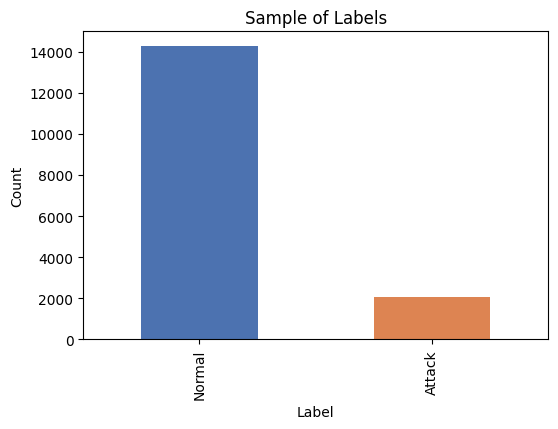

In [6]:
# Print a sample of 10 labels
sample_labels = y
print("Sample of 10 labels:")
#print(sample_labels.sample(10))
# Plot label distribution
plt.figure(figsize=(6, 4))
colors = sns.color_palette('deep')
pd.Series(y).map({0: 'Normal', 1: 'Attack'}).value_counts().plot(kind='bar', color=colors)
plt.title('Sample of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [7]:
pd.Series(y).value_counts()

Label
0    14272
1     2046
Name: count, dtype: int64

In [8]:
# Record the start time for data preprocessing
preprocessing_start_time = time.time()

# Handle infinite or large values in X
X[np.isinf(X)] = np.nan
X[np.abs(X) > np.finfo(np.float64).max] = np.nan

# Replace missing values with the mean of each feature
mean_values = np.nanmean(X, axis=0)
X = np.nan_to_num(X, nan=mean_values)

# Handle remaining NaN values if any
X[np.isnan(X)] = 0.0  # Replace NaN values with a specific value or use another imputation strategy

# Scale the features
sc_x = StandardScaler()
X = sc_x.fit_transform(X)

# Record the end time for data preprocessing
preprocessing_end_time = time.time()

# Calculate preprocessing latency
preprocessing_latency = preprocessing_end_time - preprocessing_start_time
print(f"Preprocessing Latency: {preprocessing_latency:.4f} seconds")

Preprocessing Latency: 0.2104 seconds


In [9]:
"""# Handle infinite or large values in X  هنا يتم معالجة البيانات اللامتناهية والكبيرة
X[np.isinf(X)] = np.nan
X[np.abs(X) > np.finfo(np.float64).max] = np.nan
# Replace missing values with the mean of each feature
mean_values = np.nanmean(X, axis=0)
X = np.nan_to_num(X, nan=mean_values)
    # Handle remaining NaN values if any
X[np.isnan(X)] = 0.0  # Replace NaN values with a specific value or use another imputation strategy
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
# Print the shape of the processed data
print("Shape of processed data:", X.shape)"""

'# Handle infinite or large values in X  هنا يتم معالجة البيانات اللامتناهية والكبيرة\nX[np.isinf(X)] = np.nan\nX[np.abs(X) > np.finfo(np.float64).max] = np.nan\n# Replace missing values with the mean of each feature\nmean_values = np.nanmean(X, axis=0)\nX = np.nan_to_num(X, nan=mean_values)\n    # Handle remaining NaN values if any\nX[np.isnan(X)] = 0.0  # Replace NaN values with a specific value or use another imputation strategy\nsc_x = StandardScaler()\nX = sc_x.fit_transform(X)\n# Print the shape of the processed data\nprint("Shape of processed data:", X.shape)'

In [10]:
# Store original feature indices
original_feature_indices = np.arange(X.shape[1])
# Print the original feature indices
print("Original Feature Indices:", list(original_feature_indices))

Original Feature Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
# Calculate the number of features for top 50%
num_selected_features = int(X.shape[1] * 0.5)
# Record the start time for RFE
rfe_start_time = time.time()

# Feature selection using RFE
model = LinearRegression()
rfe = RFE(model, n_features_to_select=num_selected_features)
RFE_selected = rfe.fit_transform(X,y)
# Record the end time for RFE
rfe_end_time = time.time()

# Print the selected feature indices
print(RFE_selected)
rfe_selected_indices = [i for i, selected in enumerate(rfe.support_) if selected]
print("Selected Feature Indices using RFE:", rfe_selected_indices)
# Calculate RFE latency
rfe_latency = rfe_end_time - rfe_start_time
print(f"RFE Latency: {rfe_latency:.4f} seconds")


[[ 2.22148275e-01  0.00000000e+00  0.00000000e+00 ...  6.01183558e-01
  -3.78625968e-01 -6.53705060e+01]
 [ 2.22148275e-01  0.00000000e+00  0.00000000e+00 ...  1.71545850e-01
  -3.78625968e-01 -6.53705060e+01]
 [ 2.22148275e-01  0.00000000e+00  0.00000000e+00 ...  5.44870773e-02
  -3.78625968e-01 -5.88739831e+00]
 ...
 [ 2.22148275e-01  0.00000000e+00  0.00000000e+00 ...  7.10192509e-01
  -3.78625968e-01  1.27747406e-01]
 [ 2.22148275e-01  0.00000000e+00  0.00000000e+00 ...  2.35253103e-01
  -3.78625968e-01  1.27747406e-01]
 [ 2.22148275e-01  0.00000000e+00  0.00000000e+00 ...  6.18169375e-01
  -3.78625968e-01  1.27747406e-01]]
Selected Feature Indices using RFE: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 21, 25, 26, 27, 28, 30, 31, 32, 36]
RFE Latency: 2.1712 seconds


In [12]:
import time
import numpy as np
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from joblib import Parallel, delayed

# تحويل البيانات إلى numpy لتحسين الأداء وتقليل استهلاك الذاكرة
X = np.asarray(X, dtype=np.float16)  # تقليل حجم البيانات
y = np.asarray(y, dtype=np.int8)  # تقليل حجم البيانات

# تحديد عدد الجيران بشكل ديناميكي لزيادة السرعة
optimal_neighbors = max(2, min(5, X.shape[1] // 50))  # تحديد n_neighbors تلقائيًا

# بدء تسجيل الوقت
ig_start_time = time.time()

# تشغيل Information Gain باستخدام المعالجة المتوازية
info_gain = SelectPercentile(
    score_func=lambda X, y: mutual_info_classif(X, y, n_neighbors=optimal_neighbors, n_jobs=-1),
    percentile=50
)

# تطبيق `fit_transform` على البيانات
selected_features_ig = info_gain.fit_transform(X, y)

# إنهاء تسجيل الوقت
ig_end_time = time.time()

# حساب زمن الكمون (latency)
ig_latency = ig_end_time - ig_start_time

# استخراج المؤشرات والقيم
selected_feature_indices = info_gain.get_support(indices=True)
info_gain_scores = info_gain.scores_

# طباعة النتائج
print(f"Selected Feature Indices: {selected_feature_indices}")
print(f"Information Gain Scores: {info_gain_scores}")
print(f"Super Optimized IG Latency: {ig_latency:.4f} seconds")


Selected Feature Indices: [ 1  4  7  8  9 12 13 16 17 22 25 26 30 31 32 34 35 36 37 41 42 43]
Information Gain Scores: [8.88390764e-04 1.54932513e-01 1.67795046e-03 0.00000000e+00
 4.91150179e-02 3.59714545e-03 0.00000000e+00 1.15829683e-02
 1.36350975e-01 1.35682549e-01 0.00000000e+00 1.19948395e-03
 1.39115241e-01 1.54261985e-01 1.63882806e-03 3.93431126e-05
 3.47014404e-02 1.54678226e-01 4.10006774e-04 0.00000000e+00
 1.03674708e-03 0.00000000e+00 1.38902969e-01 0.00000000e+00
 2.99026060e-03 7.05674610e-03 1.36853099e-01 7.51796701e-04
 0.00000000e+00 2.48160756e-04 5.55598768e-03 1.36427902e-01
 3.79996724e-01 4.44449513e-03 3.55342362e-01 1.45318113e-02
 1.38260094e-02 1.13877966e-02 0.00000000e+00 2.05101253e-03
 3.96085174e-03 5.04564324e-03 6.26730420e-03 3.79874160e-01]
Super Optimized IG Latency: 32.3954 seconds


In [13]:
# Find the intersection of selected features
# Find intersecting features
intersecting_features_Indices = set(selected_feature_indices) & set(rfe_selected_indices)

# Print the results
print("IG Selected Features:",list (selected_feature_indices))
print("RFE Selected Features:", rfe_selected_indices)
print("Intersecting Indiced Features :", list(intersecting_features_Indices))



IG Selected Features: [1, 4, 7, 8, 9, 12, 13, 16, 17, 22, 25, 26, 30, 31, 32, 34, 35, 36, 37, 41, 42, 43]
RFE Selected Features: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 21, 25, 26, 27, 28, 30, 31, 32, 36]
Intersecting Indiced Features : [32, 1, 36, 7, 8, 9, 16, 25, 26, 30, 31]


In [14]:
import numpy as np

# Original Feature Indices # Your array
original_indices = np.array(X)

# Convert indices to integers
intersecting_features_Indices = [int(idx) for idx in intersecting_features_Indices]

# Extract features based on given indices
intersecting_features_IG_RFE = original_indices[:, intersecting_features_Indices]

# Output the selected features
print(intersecting_features_IG_RFE)


[[-3.787e-01  2.222e-01 -6.538e+01 ...  7.759e-01 -2.411e-02  6.011e-01]
 [-3.787e-01  2.222e-01 -6.538e+01 ...  2.256e-01 -2.411e-02  1.715e-01]
 [-3.787e-01  2.222e-01 -5.887e+00 ...  7.568e-02 -2.411e-02  5.447e-02]
 ...
 [-3.787e-01  2.222e-01  1.278e-01 ...  9.155e-01 -2.411e-02  7.100e-01]
 [-3.787e-01  2.222e-01  1.278e-01 ...  3.071e-01 -2.411e-02  2.352e-01]
 [-3.787e-01  2.222e-01  1.278e-01 ...  7.974e-01 -2.411e-02  6.182e-01]]


In [15]:
import numpy as np

# Calculate the union of the sets
union_features = np.union1d(selected_feature_indices, rfe_selected_indices)

# Print the union of feature indices
print("Union of Feature:", list(union_features))

Union of Feature: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 41, 42, 43]


In [16]:
import numpy as np

# Original Feature Indices # Your array
original_indices = np.array(X)

# Convert indices to integers
union_features = [int(idx) for idx in union_features]

# Extract features based on given indices
union_features_IG_RFE = original_indices[:, union_features]

# Output the selected features
print(union_features_IG_RFE)


[[ 0.2222  0.      0.     ... -2.69   -2.48    0.3555]
 [ 0.2222  0.      0.     ... -0.368   1.365   0.3555]
 [ 0.2222  0.      0.     ... -0.368   1.365   0.3555]
 ...
 [ 0.2222  0.      0.     ... -0.095   0.4038  0.3555]
 [ 0.2222  0.      0.     ... -0.095   0.4038  0.3555]
 [ 0.2222  0.      0.     ... -0.095   0.4038  0.3555]]


In [17]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(union_features_IG_RFE, y, test_size=0.2, random_state=42)
"""
# Apply SMote to the training set
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
"""

'\n# Apply SMote to the training set\nfrom imblearn.over_sampling import SMOTE\nsmote = SMOTE(random_state=42)\nX_train, y_train = smote.fit_resample(X_train, y_train)\n'

In [18]:

#view train datase
print('\n Data X train \n', X_train.shape[0],'\n')
print('\n Data y train \n', y_train,'\n')
#view test dataset
print('\n Data X test \n', X_test.shape[0],'\n')
print('\n Data y test \n', y_test,'\n')
# train set
#print('train set: {} rows, {} columns'.format (X_train.shape[0], y_train.shape[0]),'\n')
#print('test set: {} rows, {} columns'.format (X_test.shape[0], y_test.shape[0]),'\n')

# Print shape of feature1 values
print("Shape of feature X_train values:", X_train.shape)
print("Shape of feature y_train values:",y_train.shape)
print("Shape of feature X_test values:", X_test.shape)
print("Shape of feature y_test values:",y_test.shape)


 Data X train 
 13054 


 Data y train 
 [0 0 0 ... 0 1 0] 


 Data X test 
 3264 


 Data y test 
 [0 0 0 ... 0 0 0] 

Shape of feature X_train values: (13054, 33)
Shape of feature y_train values: (13054,)
Shape of feature X_test values: (3264, 33)
Shape of feature y_test values: (3264,)


In [19]:
# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

X_train_scaled shape: (13054, 33)
X_test_scaled shape: (3264, 33)


In [20]:
# Record the start time for dimensionality reduction
dimensionality_reduction_start_time = time.time()

# Define and train the autoencoder
autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(32, activation='relu'),

    Dense(X_train_scaled.shape[1], activation='sigmoid')
])

# Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)


# Train the model
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=10, batch_size=1024,
    validation_data=(X_test_scaled, X_test_scaled),
    callbacks=[early_stopping, reduce_lr]
)

# Record the end time for dimensionality reduction
dimensionality_reduction_end_time = time.time()

# Calculate dimensionality reduction latency
dimensionality_reduction_latency = dimensionality_reduction_end_time - dimensionality_reduction_start_time
print(f"Dimensionality Reduction Latency: {dimensionality_reduction_latency:.4f} seconds")

# Print the loss history
print("Training completed")
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

Epoch 1/10
13/13 [==============================] - 3s 59ms/step - loss: 0.1792 - val_loss: 0.1692 - lr: 0.0010
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 0.1580 - val_loss: 0.1421 - lr: 0.0010
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 0.1257 - val_loss: 0.1044 - lr: 0.0010
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 0.0857 - val_loss: 0.0640 - lr: 0.0010
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 0.0491 - val_loss: 0.0340 - lr: 0.0010
Epoch 6/10
13/13 [==============================] - 0s 19ms/step - loss: 0.0262 - val_loss: 0.0196 - lr: 0.0010
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0170 - val_loss: 0.0152 - lr: 0.0010
Epoch 8/10
13/13 [==============================] - 0s 9ms/step - loss: 0.0144 - val_loss: 0.0138 - lr: 0.0010
Epoch 9/10
13/13 [==============================] - 0s 12ms/step - loss: 0.0134 - val_loss: 0.0132 - lr: 

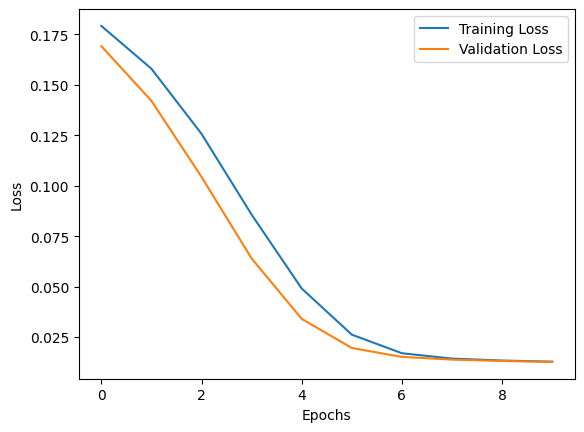

In [21]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Extract encoded features
from tensorflow.keras.models import Model
encoder = Model(autoencoder.input, autoencoder.layers[1].output)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Display the shape of the encoded features to verify
print("Shape of encoded features for training set:", X_train_encoded.shape)
print("Shape of encoded features for test set:", X_test_encoded.shape)

102/102 [==============================] - 0s 3ms/step
Shape of encoded features for training set: (13054, 8)
Shape of encoded features for test set: (3264, 8)


In [23]:
import numpy as np

# حساب حجم البيانات الأصلية
original_size_train = X_train.nbytes
original_size_test = X_test.nbytes

# حساب حجم البيانات بعد الضغط
compressed_size_train = X_train_encoded.nbytes
compressed_size_test = X_test_encoded.nbytes

# حساب نسبة الضغط
compression_ratio_train = original_size_train / compressed_size_train
compression_ratio_test = original_size_test / compressed_size_test

print(f"Original Training Data Size: {original_size_train / (1024**2):.2f} MB")
print(f"Compressed Training Data Size: {compressed_size_train / (1024**2):.2f} MB")
print(f"Compression Ratio (Train): {compression_ratio_train:.2f}x")

print(f"Original Testing Data Size: {original_size_test / (1024**2):.2f} MB")
print(f"Compressed Testing Data Size: {compressed_size_test / (1024**2):.2f} MB")
print(f"Compression Ratio (Test): {compression_ratio_test:.2f}x")


Original Training Data Size: 0.82 MB
Compressed Training Data Size: 0.40 MB
Compression Ratio (Train): 2.06x
Original Testing Data Size: 0.21 MB
Compressed Testing Data Size: 0.10 MB
Compression Ratio (Test): 2.06x


In [25]:
from sklearn.metrics import mean_squared_error

# استخراج البيانات المستعادة باستخدام Autoencoder
X_train_reconstructed = autoencoder.predict(X_train_scaled)
X_test_reconstructed = autoencoder.predict(X_test_scaled)

# حساب MSE للبيانات التدريبية
mse_train = mean_squared_error(X_train_scaled, X_train_reconstructed)
# حساب MSE للبيانات الاختبارية
mse_test = mean_squared_error(X_test_scaled, X_test_reconstructed)

# طباعة النتائج
print(f"Mean Squared Error (Train): {mse_train:.6f}")
print(f"Mean Squared Error (Test): {mse_test:.6f}")


102/102 [==============================] - 0s 3ms/step
Mean Squared Error (Train): 0.012568
Mean Squared Error (Test): 0.012695


In [217]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode the training labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels for multi-class classification
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)



In [218]:
y_train_one_hot.shape 

(13054, 2)

In [219]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import time
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define the DNN model
DNN_model = Sequential()
DNN_model.add(Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)))
DNN_model.add(Dense(32, activation='relu'))
DNN_model.add(Dense(16, activation='relu'))
#DNN_model.add(Dropout(0.5))  # Uncomment to add dropout if needed
DNN_model.add(Dense(1, activation='sigmoid'))  # Single output neuron with sigmoid for binary classification

# Compile the model
DNN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

# Record the start time
start_time = time.time()

# Train the model
history = DNN_model.fit(
    X_train_encoded, y_train_encoded,  # Assuming y_train_encoded is binary (0 or 1)
    epochs=10, batch_size=256,
    validation_data=(X_test_encoded, y_test_encoded),  # Assuming y_test_encoded is binary (0 or 1)
    callbacks=[early_stopping, reduce_lr]
)

# Record the end time
end_time = time.time()

Epoch 1/10
51/51 [==============================] - 1s 6ms/step - loss: 0.3695 - accuracy: 0.8751 - val_loss: 0.3371 - val_accuracy: 0.8725 - lr: 0.0010
Epoch 2/10
51/51 [==============================] - 0s 3ms/step - loss: 0.3097 - accuracy: 0.8751 - val_loss: 0.2783 - val_accuracy: 0.8725 - lr: 0.0010
Epoch 3/10
51/51 [==============================] - 0s 3ms/step - loss: 0.2258 - accuracy: 0.8793 - val_loss: 0.1660 - val_accuracy: 0.9148 - lr: 0.0010
Epoch 4/10
51/51 [==============================] - 0s 3ms/step - loss: 0.1129 - accuracy: 0.9672 - val_loss: 0.0691 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 5/10
51/51 [==============================] - 0s 3ms/step - loss: 0.0440 - accuracy: 0.9993 - val_loss: 0.0264 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 6/10
51/51 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9996 - val_loss: 0.0143 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 7/10
51/51 [==============================] - 0s 3ms/step - loss: 0.0106 - a

In [220]:
# Print the loss and accuracy history
print("Training completed")
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])

Training completed
Final training loss: 0.00396429980173707
Final validation loss: 0.0036264979280531406
Final training accuracy: 0.9996169805526733
Final validation accuracy: 0.999387264251709


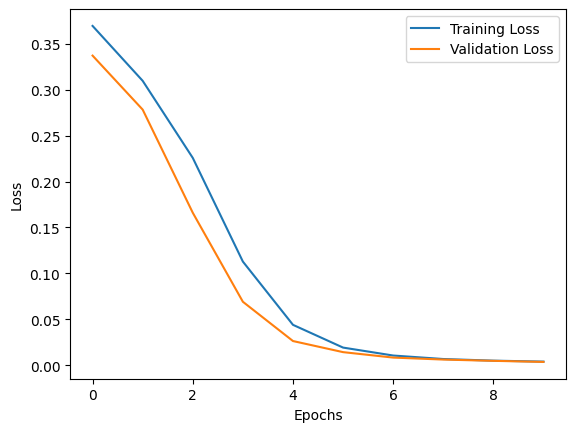

In [221]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [222]:
# Record the start time for classification
classification_start_time = time.time()

# Make predictions using the trained DNN model
y_pred_probs = DNN_model.predict(X_test_encoded)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# Record the end time for classification
classification_end_time = time.time()

# Calculate classification latency
classification_latency = classification_end_time - classification_start_time
print(f"Classification Latency: {classification_latency:.4f} seconds")

102/102 [==============================] - 0s 1ms/step
Classification Latency: 0.3331 seconds


In [223]:
print(preprocessing_latency, rfe_latency, ig_latency, dimensionality_reduction_latency, classification_latency)

0.04687309265136719 0.40196895599365234 2.0136184692382812 1.6342828273773193 0.33310842514038086


In [224]:
# Calculate total real-time latency
total_real_time_latency = preprocessing_latency + rfe_latency + ig_latency + dimensionality_reduction_latency + classification_latency
print(f"Total Real-Time Latency: {total_real_time_latency:.4f} seconds")

Total Real-Time Latency: 4.4299 seconds


In [225]:
# Compute the confusion matrix
confmatrx = confusion_matrix(y_test_encoded, y_pred_classes)

# Extract metrics from confusion matrix
tp = confmatrx[1, 1]
fn = confmatrx[1, 0]
fp = confmatrx[0, 1]
tn = confmatrx[0, 0]

# Calculate metrics
accuracy = accuracy_score(y_test_encoded, y_pred_classes) * 100
precision = precision_score(y_test_encoded, y_pred_classes) * 100
recall = recall_score(y_test_encoded, y_pred_classes) * 100
f1 = f1_score(y_test_encoded, y_pred_classes) * 100
mcc = matthews_corrcoef(y_test, y_pred_classes)

In [226]:
# Additional metrics
fn_rate = fn / (tp + fn)
fp_rate = fp / (tn + fp)
error_rate = (fp + fn) / (tp + tn + fp + fn)
dr = tp / (tp + fn)
adr = tp / (tp + tn)

total_instances = tp + fn
cost_fp = precision / (tn / (tn + fp)) if (tn + fp) > 0 else 0
cost_fn = dr / precision if precision > 0 else 0
ici = (fp * cost_fp + fn * cost_fn) / total_instances if total_instances > 0 else 0
far = fp / (fp + tn) if (fp + tn) > 0 else 0

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}%")
print(f"Precision: {precision:.4f}%")
print(f"Recall: {recall:.4f}%")
print(f"F1 Score: {f1:.4f}%","\n")
print(f"False Negative Rate: {fn_rate:.4f}")
print(f"False Positive Rate: {fp_rate:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print(f"Detection Rate: {dr:.4f}")
print(f"Attack Detection Rate: {adr:.4f}")
print(f"Incorrect Classification Insurance: {ici:.4f}")
print(f"False Alarm Rate: {far:.4f}","\n")

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")

# Compute MCC (Matthew’s Correlation Coefficient)
mcc = matthews_corrcoef(y_test_encoded, y_pred_classes)
print(f"Matthew's Correlation Coefficient (MCC): {mcc:.4f}","\n")
# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")
print(f"Total Real-Time Latency: {total_real_time_latency:.4f} seconds")

Accuracy: 99.9387%
Precision: 99.5215%
Recall: 100.0000%
F1 Score: 99.7602% 

False Negative Rate: 0.0000
False Positive Rate: 0.0007
Error Rate: 0.0006
Detection Rate: 1.0000
Attack Detection Rate: 0.1275
Incorrect Classification Insurance: 0.4788
False Alarm Rate: 0.0007 

ROC AUC: 1.0000
Matthew's Correlation Coefficient (MCC): 0.9973 

Training time: 2.27 seconds
Total Real-Time Latency: 4.4299 seconds


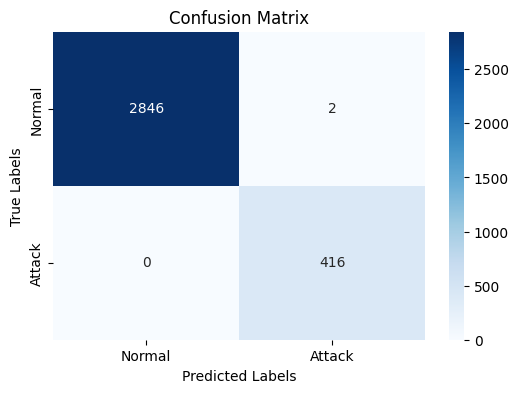

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2848
      Attack       1.00      1.00      1.00       416

    accuracy                           1.00      3264
   macro avg       1.00      1.00      1.00      3264
weighted avg       1.00      1.00      1.00      3264



array([[2846,    2],
       [   0,  416]], dtype=int64)

In [227]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confmatrx, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred_classes, target_names=['Normal', 'Attack']))
confmatrx